In [1]:
import seaborn as sns
import numpy as np
import scipy
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
%pylab inline
import os
from __future__ import print_function
from __future__ import division
import os, sys
# hook up all scripts
sys.path.append(os.path.abspath('../scripts')) # if notebook in folder
sys.path.append(os.path.abspath('./scripts')) #if in root
import preprocessing_time_series as pts

os.chdir(pts.working_dir() + 'Feature_releases/release_v02/')

Populating the interactive namespace from numpy and matplotlib


In [2]:
feat_imp_week10 = pd.Series.from_csv('feat_imp_week10_xgboost_release_v02.csv')
feat_imp_week11 = pd.Series.from_csv('feat_imp_week11_xgboost_release_v02.csv')
feat_week10 = list(feat_imp_week10[:50].index)
feat_week11 = list(feat_imp_week11[:50].index)

In [3]:
data_train = pd.read_csv('train_MORELOS.csv')
print(data_train.shape)
data_train.head()

/home/romul/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (25,26) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(1533670, 133)


,Agencia_ID,Canal_ID,Cliente_ID,Demanda_uni_equil,Dev_proxima,Dev_proxima_by_uni,Dev_uni_proxima,Log_Demanda,Log_Demanda_Mean_Producto_ID_Cliente_ID_Agencia_ID,Log_Demanda_Mean_Producto_ID_Cliente_ID_Ruta_SAK,...,Log_Venta_uni_hoy_Mean_Producto_ID_Cliente_ID_Ruta_SAK_4last,No_remains_4last,No_remains_Mean_Producto_ID_Cliente_ID_Agencia_ID_4last,No_remains_Mean_Producto_ID_Cliente_ID_Ruta_SAK_4last,Ordered_4last,Ordered_Mean_Producto_ID_Cliente_ID_Agencia_ID_4last,Ordered_Mean_Producto_ID_Cliente_ID_Ruta_SAK_4last,Venta_hoy_4last,Venta_hoy_by_uni_4last,Venta_uni_hoy_4last
0,1239,1,78533,1.0,0.00,NaN,0.0,0.693147,0.924196,0.924196,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1239,1,78533,8.0,0.00,NaN,0.0,2.197225,1.805367,1.903331,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1239,1,78533,0.0,42.78,21.39,2.0,0.000000,0.780355,0.823959,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1239,1,78533,11.0,0.00,NaN,0.0,2.484907,1.690393,1.690393,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1239,1,78533,17.0,0.00,NaN,0.0,2.890372,1.958004,1.958004,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
means_by_split = [x for x in data_train.columns if 'Mean' in x and not(x[-2] == '_' or x[-4:] == 'last')] #its mean, its not a lag
print(means_by_split)
data_for_model = data_train.drop([u'Town', u'State', u'Venta_uni_hoy', u'Venta_hoy', u'Dev_uni_proxima',
       u'Dev_proxima', u'Demanda_uni_equil', u'Dev_proxima_by_uni', u'No_remains', 
        u'Venta_hoy_by_uni', u'Ordered'] + means_by_split, axis=1).set_index(u'Semana')

['Log_Demanda_Mean_Producto_ID_Cliente_ID_Agencia_ID', 'Log_Demanda_Mean_Producto_ID_Cliente_ID_Ruta_SAK', 'Log_Venta_uni_hoy_Mean_Producto_ID_Cliente_ID_Agencia_ID', 'Log_Venta_uni_hoy_Mean_Producto_ID_Cliente_ID_Ruta_SAK', 'No_remains_Mean_Producto_ID_Cliente_ID_Agencia_ID', 'No_remains_Mean_Producto_ID_Cliente_ID_Ruta_SAK', 'Ordered_Mean_Producto_ID_Cliente_ID_Agencia_ID', 'Ordered_Mean_Producto_ID_Cliente_ID_Ruta_SAK']


In [5]:
X_train = data_for_model.loc[3:7,:].drop('Log_Demanda', axis=1)
y_train = data_for_model.loc[3:7,:]['Log_Demanda']
X_test = data_for_model.loc[8:9,:].drop('Log_Demanda', axis=1)
y_test = data_for_model.loc[8:9,:]['Log_Demanda']
X_train.head()

,Agencia_ID,Canal_ID,Cliente_ID,Log_Dev_proxima,Log_Dev_uni_proxima,Log_Venta_hoy,Log_Venta_uni_hoy,Producto_ID,Ruta_SAK,brand,...,Log_Venta_uni_hoy_Mean_Producto_ID_Cliente_ID_Ruta_SAK_4last,No_remains_4last,No_remains_Mean_Producto_ID_Cliente_ID_Agencia_ID_4last,No_remains_Mean_Producto_ID_Cliente_ID_Ruta_SAK_4last,Ordered_4last,Ordered_Mean_Producto_ID_Cliente_ID_Agencia_ID_4last,Ordered_Mean_Producto_ID_Cliente_ID_Ruta_SAK_4last,Venta_hoy_4last,Venta_hoy_by_uni_4last,Venta_uni_hoy_4last
Semana,,,,,,,,,,,,,,,,,,,,,
3,1239,1,78533,0.0,0.0,1.0,1.0,1109,1020,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1239,1,78533,0.0,0.0,1.0,1.0,1125,1020,39.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1239,1,78533,1.0,1.0,1.0,1.0,1146,1020,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1239,1,78533,0.0,0.0,1.0,1.0,1150,1020,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1239,1,78533,0.0,0.0,1.0,1.0,1160,1020,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# xgboost 

Обнаружил, что для learning_rate=0.3 оптимальное количество деревьев 100.

Подобраны параметры max_depth=16 и min_child_weight=18.

Подбираю gamma

Потом надо подобрать [subsample, colsample_bytree], [lambda(L2), alpha(L1)]. 

In [6]:
import xgboost as xgb
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import mean_squared_error

def plot_feature_importances(xgb_model):
    plt.figure(figsize=(20,10))
    feat_imp = pd.Series(xgb_model.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

In [7]:
# param = clf.best_params_
param = {
 'learning_rate': 0.3,
 'gamma': 1,
 'max_depth': 16,
 'min_child_weight': 18,
 'n_estimators': 100,
 'subsample': 0.8,
 'colsample_bytree': 0.8
}

xgb_model = xgb.XGBRegressor()
xgb_model.set_params(**param)

xgb_model.fit(X_train[feat_week10], y_train)

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=1, learning_rate=0.3, max_delta_step=0, max_depth=16,
       min_child_weight=18, missing=None, n_estimators=100, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.8)

Train: 0.343021397306
Test: 0.328642142572


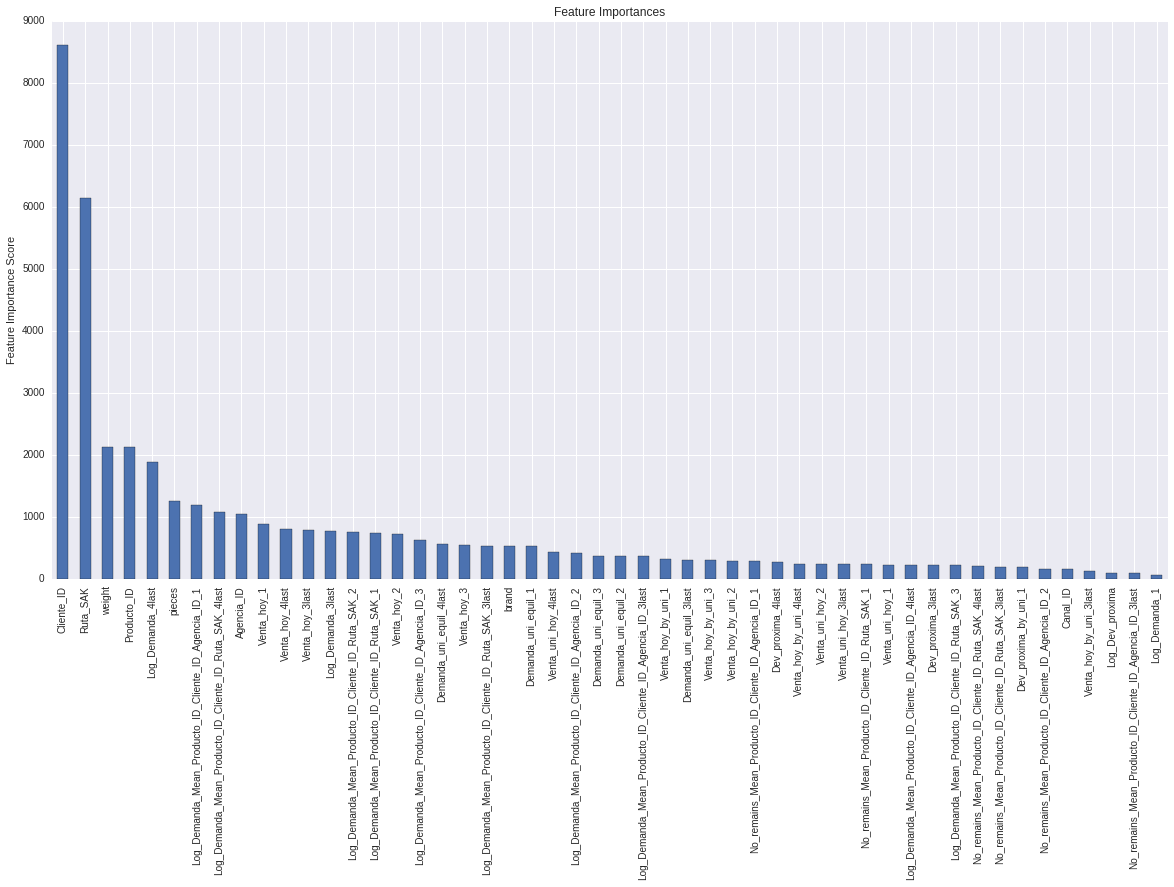

In [8]:
plot_feature_importances(xgb_model)

print('Train:', np.sqrt(mean_squared_error(y_train, xgb_model.predict(X_train[feat_week10]))))
print('Test:', np.sqrt(mean_squared_error(y_test, xgb_model.predict(X_test[feat_week10]))))

In [9]:
feat_imp_week10 = pd.Series(xgb_model.booster().get_fscore()).sort_values(ascending=False)
#feat_imp_week10.to_csv('feat_imp_week10_xgboost_release_v02.csv')

# Next week prediction

In [11]:
X_train2 = X_train[[col for col in X_train.columns if '_1' != col[-2:]]]
X_test2 = X_test[[col for col in X_test.columns if '_1' != col[-2:]]]
X_train2.shape, X_train.shape

((1008601, 92), (1008601, 112))

In [12]:
param = {
 'learning_rate': 0.3,
 'gamma': 1,
 'max_depth': 16,
 'min_child_weight': 18,
 'n_estimators': 100,
 'subsample': 0.8,
 'colsample_bytree': 0.8
}

xgb_model2 = xgb.XGBRegressor()
xgb_model2.set_params(**param)

xgb_model2.fit(X_train2[feat_week11], y_train)

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=1, learning_rate=0.3, max_delta_step=0, max_depth=16,
       min_child_weight=18, missing=None, n_estimators=100, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.8)

Train: 0.342346534228
Test: 0.326433050146


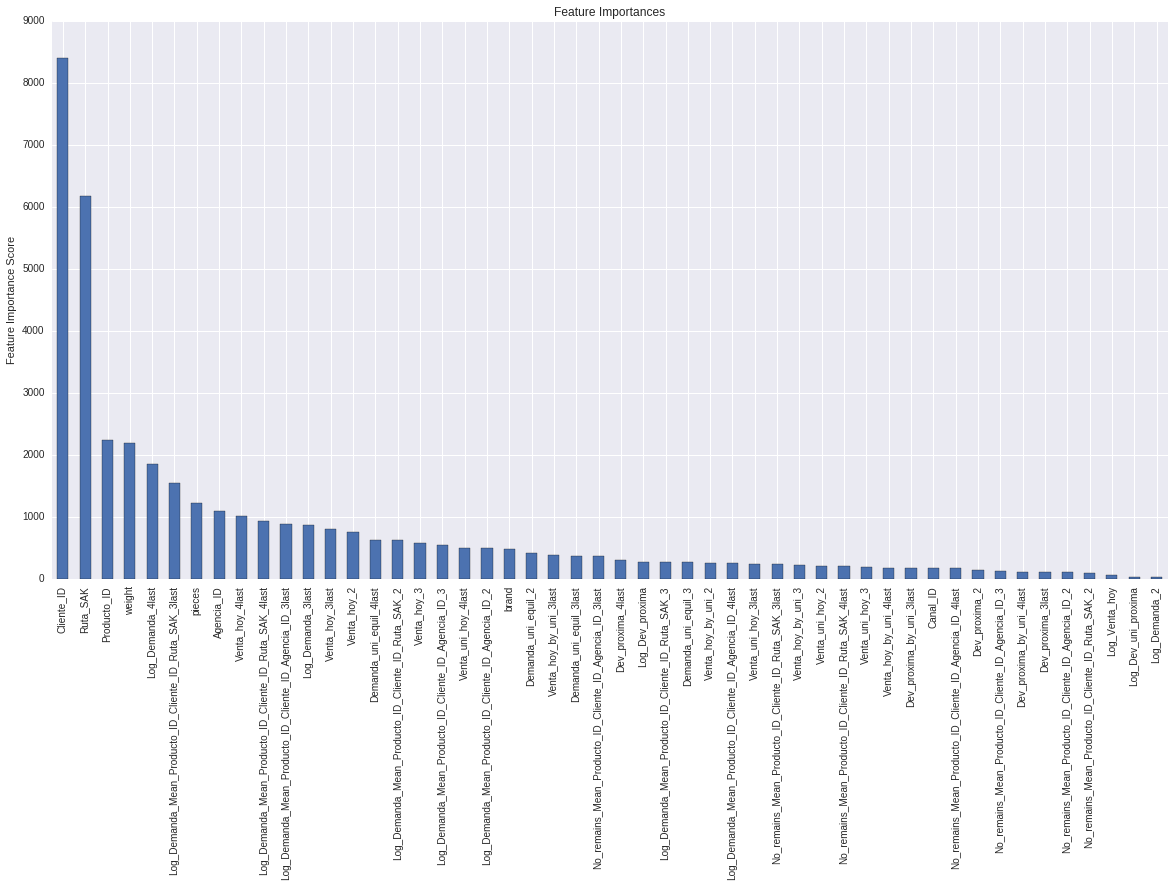

In [13]:
plot_feature_importances(xgb_model2)

print('Train:', np.sqrt(mean_squared_error(y_train, xgb_model2.predict(X_train2[feat_week11]))))
print('Test:', np.sqrt(mean_squared_error(y_test, xgb_model2.predict(X_test2[feat_week11]))))

In [14]:
feat_imp_week11 = pd.Series(xgb_model2.booster().get_fscore()).sort_values(ascending=False)
#feat_imp_week11.to_csv('feat_imp_week11_xgboost_release_v02.csv')

# Cross-validation

In [ ]:
param = {
 'eta': 0.3,
 'gamma': 0,
 'max_depth': 15,
 'min_child_weight': 12,
 'n_estimators': 100,
 'subsample': 0.8,
 'colsample_bytree': 0.8
}

xgtrain = xgb.DMatrix(X_train.values, label=y_train.values)
cvresult = xgb.cv(param, xgtrain, num_boost_round=200, nfold=5,
                    metrics='rmse', early_stopping_rounds=10)
cvresult

In [ ]:
grid_param = {
 'max_depth': [15, 17, 20, 23, 25],
 'min_child_weight': [5, 8, 10, 12],
}

xgb_model = xgb.XGBRegressor(n_estimators=78,
                             learning_rate = 0.3,
                             gamma=0,
                             subsample=0.8,
                             colsample_bytree=0.8)

clf = GridSearchCV(xgb_model, grid_param, cv=5,
                   scoring='mean_squared_error',verbose=1, n_jobs=-1)
clf.fit(X_train, y_train)

print(clf.best_score_)
print(clf.best_params_)
clf.grid_scores_

In [ ]:
plot_feature_importances(clf.best_estimator_)

# Grid search without cross-validation

In [20]:
from gridsearch import GridSearch

In [ ]:
param_grid = {
    'max_depth': [13, 16, 19],
    'min_child_weight': [15, 18, 21]
}

xgb_model = xgb.XGBRegressor(n_estimators=100,
                             learning_rate = 0.3,
                             subsample=0.8,
                             colsample_bytree=0.8,
                             gamma=1)

gs = GridSearch(xgb_model, param_grid, verbose=1)
    
gs.fit(X_train, X_test, y_train, y_test)

Fitting 9 candidates


In [ ]:
gs.best_score_

In [ ]:
gs.best_params_